In [1]:
%matplotlib inline
# %matplotlib notebook
import pandas as pd
import DataHelper
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
e = DataHelper.eclass_data()

In [3]:
e.cis.Q15.unique()

array([nan, '4 year college', "Master's granting institution",
       'PhD granting institution', '2 year college'], dtype=object)

In [4]:
def return_race(rcode):
    """
    Returns the racial identifier from IPEDS definitions
    
    All 'unknown' columns are reduced to 'Not Reported'
    
    'American Indian or Alaska Native' and 'Native Hawaiian or other Pacific Islander'
    are counted as 'Not Reported' due to the very low numbers (<100) of data gathered for
    them it will not be fair to characterize results of these students
    """
    race_codes = {
#         '10000000':'American Indian or Alaska Native'
        '10000000':'Not Reported'
                  , '01000000':'Asian'
                  , '00100000':'Black'
                  , '00010000':'Hispanic/Latino'
#                   , '00001000':'Native Hawaiian or other Pacific Islander'
                  , '00001000':'Not Reported'
                  , '00000100':'White'
                 }
    try:
        return race_codes[rcode]
    except KeyError:
        return 'Not Reported'

races = e.post.set_index('anon_student_id')[[ 'Q52_1', 'Q52_2', 'Q52_3', 'Q52_4', 'Q52_5', 'Q52_6', 'Q52_7', 'race_unknown']].fillna(0).astype(int).astype(str)

races = (races[ 'Q52_1'] + races['Q52_2'] + races['Q52_3'] + races['Q52_4'] + races['Q52_5'] + races['Q52_6'] + races['Q52_7'] + races['race_unknown'])    

races = races.apply(return_race)
races = pd.DataFrame({'Race':races})


In [5]:
gender = e.post[['anon_student_id','Q54']].drop_duplicates().set_index('anon_student_id')#
gender.columns = ['Gender']

In [6]:
buffy_student = pd.DataFrame(index=pd.concat([e.get_buffy_pre(), e.get_buffy_post()]).anon_student_id.unique())
buffy_student['BUFFY'] = 1

In [7]:
future_plans = e.post[['anon_student_id', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6', 'Q53_7', 'Q53_8']].set_index('anon_student_id')

In [8]:
index = np.arange(0, pd.concat([e.pre.anon_student_id, e.post.anon_student_id]).max()+1, 1)
students = pd.DataFrame(index=index)

students = students.join(races, how='left').join(gender, how='left').join(buffy_student, how='left').join(future_plans).reset_index()
students = students.drop_duplicates(subset=['index'], keep='first').set_index('index').dropna(how='all')
students['BUFFY'] = students['BUFFY'].fillna(0)

students

,Race,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8
index,,,,,,,,,,,
5,Hispanic/Latino,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0
6,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,White,2.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0
8,Black,1.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
10,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
43076,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43077,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43078,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [9]:
students

,Race,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8
index,,,,,,,,,,,
5,Hispanic/Latino,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0
6,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,White,2.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0
8,Black,1.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
10,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
43076,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43077,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43078,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [10]:
e.cis[['Q15', 'anon_instructor_id', 'anon_university_id', 'ResponseId']]

,Q15,anon_instructor_id,anon_university_id,ResponseId
0,NaN,0,0,R_5vvkiNRDrvutGdX
1,4 year college,1,1,R_5mXbzVvsHehQ07L
2,NaN,1,1,R_1g28mGAPrOOZ4Mh
3,4 year college,2,1,R_1pL1oZ2Un6TQfkp
4,4 year college,3,2,R_2ritbcOI1sEN5mn
...,...,...,...,...
594,4 year college,203,132,R_3qJOKOP2r5VyMrj
595,PhD granting institution,69,32,R_3nu6XUP5nAi4lZe
596,NaN,69,32,R_qITeC301YGuhQNr
597,NaN,69,32,R_A72jufifWSmfboZ


In [11]:
alldata = pd.concat([e.pre, e.post])
cis_connector = alldata[['anon_student_id', 'ResponseId']].drop_duplicates().drop_duplicates(subset='anon_student_id').set_index('anon_student_id')
students = students.join(cis_connector).merge(e.cis[['Q15', 'anon_instructor_id', 'anon_university_id', 'ResponseId']])

# drop all students who don't have institution type responses in CIS
students.dropna(subset=['Q15'], inplace=True)

In [12]:
# data = pd.get_dummies(students)
# data.dropna(inplace=True)

In [13]:
cols = ['Race', 'Gender', 'BUFFY', 'Q53_1', 'Q53_2','Q53_3','Q53_4','Q53_5','Q53_6','Q53_7','Q53_8','Q15','anon_instructor_id','anon_university_id']

pd.get_dummies(students[cols]).columns

Index(['Gender', 'BUFFY', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6',
       'Q53_7', 'Q53_8', 'anon_instructor_id', 'anon_university_id',
       'Race_Asian', 'Race_Black', 'Race_Hispanic/Latino', 'Race_Not Reported',
       'Race_White', 'Q15_2 year college', 'Q15_4 year college',
       'Q15_Master's granting institution', 'Q15_PhD granting institution'],
      dtype='object')

In [14]:
xcols = ['Gender', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6',
       'Q53_7', 'Q53_8'
#          , 'anon_instructor_id', 'anon_university_id','Race_American Indian or Alaska Native'
         , 'Race_Asian', 'Race_Black', 'Race_Hispanic/Latino'
#        'Race_Native Hawaiian or other Pacific Islander'
         , 'Race_Not Reported'
         , 'Race_White'
#          , 'Q15_2 year college'
         , 'Q15_4 year college',
       "Q15_Master's granting institution", 'Q15_PhD granting institution']
ycol = 'BUFFY'

data = pd.get_dummies(students[cols])
print(data.shape)
data = data[data['Q15_2 year college']==0]
data.dropna(inplace=True)
print(data.shape)

# X_train, X_test, y_train, y_test = train_test_split(data[xcols], data[ycol])

(11329, 21)
(10148, 21)


In [15]:
KF = KFold(n_splits = 5, shuffle = True)

num_round = 30000
param = {'max_depth': 2, 'eta': 0.3, 'objective': 'reg:logistic'}
param['nthread'] = 18
param['eval_metric'] = 'auc'
# this might produce data leakage but for now i guess its okay
param['scale_pos_weight'] = data.BUFFY.count()/data.BUFFY.sum()

logreg = []
xgmod = []

lr_auc = []
xg_auc = []

n = 1

KF_index = KF.split(data)

trains = []
tests = []

# for train, test in KF.split(data):
for train, test in KF_index:
    trains.append(train)
    tests.append(test)
    
    X_train = data[xcols].iloc[train]
    y_train = data[ycol].iloc[train]
    
    X_test = data[xcols].iloc[test]
    y_test = data[ycol].iloc[test]
    
    logit_mod = sm.Logit(exog=X_train, endog=y_train)
    logit_res = logit_mod.fit()
#     preds = logit_res.predict(X_test)
    preds = logit_res.predict(X_test)
    logreg.append(preds)
    
    auc = metrics.roc_auc_score(y_true=y_test, y_score=preds)
    lr_auc.append(auc)
    print('logreg k={n} fold AUC='.format(n=n), auc)
    
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999.0)
    dtest = xgb.DMatrix(X_test, label=y_test, missing=-999.0)

    bst = xgb.train(param, dtrain, num_round)
    
#     classify = lambda x: 0 if x < 0.5 else 1
#     preds = [classify(y) for y in bst.predict(dtest)]
#     xgmod.append(preds)
    preds = bst.predict(dtest)
    xgmod.append(preds)
    
    auc = metrics.roc_auc_score(y_true=y_test, y_score=preds)
    print('xgboost k={n} fold AUC='.format(n=n), auc)
    xg_auc.append(auc)
    
    n += 1

Optimization terminated successfully.
         Current function value: 0.319267
         Iterations 7
logreg k=1 fold AUC= 0.784957685458851
xgboost k=1 fold AUC= 0.8234779156646412
Optimization terminated successfully.
         Current function value: 0.314263
         Iterations 7
logreg k=2 fold AUC= 0.7742933012804118
xgboost k=2 fold AUC= 0.7928920941810308
Optimization terminated successfully.
         Current function value: 0.311809
         Iterations 8
logreg k=3 fold AUC= 0.752025882460665
xgboost k=3 fold AUC= 0.7713919453049889
Optimization terminated successfully.
         Current function value: 0.316220
         Iterations 7
logreg k=4 fold AUC= 0.789644058235621
xgboost k=4 fold AUC= 0.796914898656068
Optimization terminated successfully.
         Current function value: 0.311992
         Iterations 10
logreg k=5 fold AUC= 0.7669214132717782
xgboost k=5 fold AUC= 0.786832199970886


In [16]:
np.mean(lr_auc)

0.7735684681414654

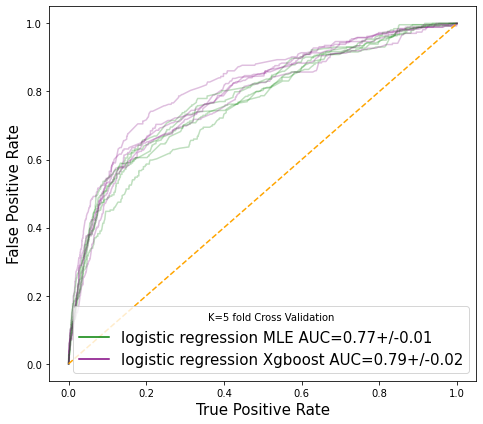

In [17]:
fig, ax = plt.subplots(figsize=(7, 6))

plt.plot([],[], color='green', label='logistic regression MLE AUC='+ str(np.mean(lr_auc).round(2))+ '+/-'+ str(np.std(lr_auc).round(2)))

plt.plot([],[], color='purple', label='logistic regression Xgboost AUC='+ str(np.mean(xg_auc).round(2))+ '+/-'+ str(np.std(xg_auc).round(2)))
ax.legend(fontsize=15, title='K=5 fold Cross Validation') 

for k in np.arange(0, 5, 1):
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true=data[ycol].iloc[tests[k]], y_score=logreg[k])
    ax.plot(fpr, tpr, color='green', alpha=0.25, label='K={k} fold logistic regression MLE'.format(k=k+1))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true=data[ycol].iloc[tests[k]], y_score=xgmod[k])
    ax.plot(fpr, tpr, color='purple', alpha=0.25, label='K={k} fold logistic regression Xgboost'.format(k=k+1))
    
ax.plot([0, 1], [0, 1], color='orange', linestyle='--')
ax.set_ylabel('False Positive Rate', fontsize=15)
ax.set_xlabel('True Positive Rate', fontsize=15)
fig.tight_layout()
fig.savefig('roc.pdf', bbox_inches='tight')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

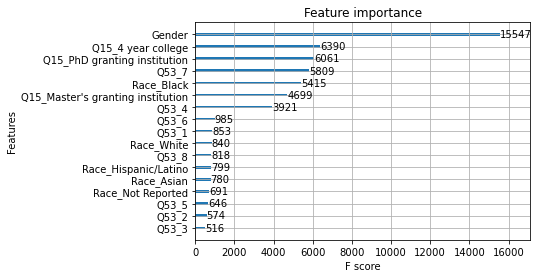

In [18]:
xgb.plot_importance(bst)

In [19]:
races

,Race
anon_student_id,
19470,Not Reported
19474,Not Reported
19464,Not Reported
19469,Not Reported
19467,Not Reported
...,...
4973,Asian
36453,White
4976,Not Reported


In [ ]:
# TODO : restructure data set so that
# 1. all column names have no spaces
# 2. the institution column is restructured to be 3 item categorical
# 3. input data into GLM model
# 4. add to ROC curves

In [20]:
import statsmodels.genmod.bayes_mixed_glm as smgb


In [21]:
random = {"a": '0 + Gender', "b": '0 + Gender'} 
model = smgb.BinomialBayesMixedGLM.from_formula('BUFFY ~ Gender + Q53_1', random, X_train.join(y_train))
result = model.fit_vb()

In [22]:
result.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,2.0468,0.0358,,,
Gender,M,0.0638,0.0208,,,
Q53_1,M,-2.2978,0.0206,,,
a,V,-0.9794,0.9800,0.376,0.053,2.666
b,V,-0.9794,0.9800,0.376,0.053,2.666


In [23]:
metrics.roc_auc_score(y_true=y_test, y_score=result.predict(X_test[['Gender', 'Q53_1']]))

0.4075176243059454

In [24]:
[x.replace(' ', '_').replace("'", "") for x in X_train.columns]

['Gender',
 'Q53_1',
 'Q53_2',
 'Q53_3',
 'Q53_4',
 'Q53_5',
 'Q53_6',
 'Q53_7',
 'Q53_8',
 'Race_Asian',
 'Race_Black',
 'Race_Hispanic/Latino',
 'Race_Not_Reported',
 'Race_White',
 'Q15_4_year_college',
 'Q15_Masters_granting_institution',
 'Q15_PhD_granting_institution']

In [25]:
X_train.columns

Index(['Gender', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6', 'Q53_7',
       'Q53_8', 'Race_Asian', 'Race_Black', 'Race_Hispanic/Latino',
       'Race_Not Reported', 'Race_White', 'Q15_4 year college',
       'Q15_Master's granting institution', 'Q15_PhD granting institution'],
      dtype='object')

In [26]:
X_train[['Q15_4 year college', "Q15_Master's granting institution", 'Q15_PhD granting institution']]

,Q15_4 year college,Q15_Master's granting institution,Q15_PhD granting institution
132,1,0,0
133,1,0,0
134,1,0,0
136,1,0,0
137,1,0,0
...,...,...,...
30343,1,0,0
30344,1,0,0
30345,1,0,0
30346,1,0,0


In [27]:
(X_train['Q15_4 year college'].apply(lambda x: '4year' if x==1 else '') + X_train["Q15_Master's granting institution"].apply(lambda x: 'masters' if x==1 else '') + X_train['Q15_PhD granting institution'].apply(lambda x: 'phd' if x==1 else '')).unique()

array(['4year', 'phd', 'masters'], dtype=object)

In [28]:
X_train[(X_train['Q15_4 year college']==0) & (X_train["Q15_Master's granting institution"]==1) & (X_train['Q15_PhD granting institution']==0)]

,Gender,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8,Race_Asian,Race_Black,Race_Hispanic/Latino,Race_Not Reported,Race_White,Q15_4 year college,Q15_Master's granting institution,Q15_PhD granting institution
2036,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,0,0,0,1,0,0,1,0
2037,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,0,0,0,1,0,0,1,0
2039,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,0,1,0,0,1,0
2040,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0,0,0,1,0,0,1,0
2041,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30208,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0,0,0,1,0,0,1,0
30210,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0,0,0,1,0,0,1,0
30211,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,0,0,0,1,0,0,1,0
30212,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,0,1,0,0,1,0


In [29]:
students[students.Q15!='2 year college'].dropna(subset=['Q15'])

,Race,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8,ResponseId,Q15,anon_instructor_id,anon_university_id
131,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R_10OatPJO1akPvoS,4 year college,47,19
132,White,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,R_10OatPJO1akPvoS,4 year college,47,19
133,White,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,R_10OatPJO1akPvoS,4 year college,47,19
134,White,2.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,R_10OatPJO1akPvoS,4 year college,47,19
135,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R_10OatPJO1akPvoS,4 year college,47,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30344,White,1.0,0.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,R_Tu5KuQkIjcZhAlP,4 year college,36,13
30345,Not Reported,3.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,R_Tu5KuQkIjcZhAlP,4 year college,36,13
30346,Hispanic/Latino,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,R_Tu5KuQkIjcZhAlP,4 year college,36,13
30347,Hispanic/Latino,1.0,0.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,R_Tu5KuQkIjcZhAlP,4 year college,36,13


In [30]:
e.cis['Q15'].unique()

array([nan, '4 year college', "Master's granting institution",
       'PhD granting institution', '2 year college'], dtype=object)

In [31]:
students

,Race,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8,ResponseId,Q15,anon_instructor_id,anon_university_id
131,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R_10OatPJO1akPvoS,4 year college,47,19
132,White,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,R_10OatPJO1akPvoS,4 year college,47,19
133,White,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,R_10OatPJO1akPvoS,4 year college,47,19
134,White,2.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,R_10OatPJO1akPvoS,4 year college,47,19
135,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R_10OatPJO1akPvoS,4 year college,47,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30427,Black,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,R_3OqsaiqnFYJNNF5,2 year college,122,71
30428,Not Reported,1.0,0.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,R_3OqsaiqnFYJNNF5,2 year college,122,71
30429,Asian,2.0,0.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,R_3OqsaiqnFYJNNF5,2 year college,122,71
30430,White,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,R_3OqsaiqnFYJNNF5,2 year college,122,71
